In [3]:
import json
import os
import time
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import collections

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchsummary import summary

from model_pytorch import resnext50_32x4d
from utils import Bar,Logger, AverageMeter, accuracy, mkdir_p, savefig
from warmup_scheduler import GradualWarmupScheduler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from scipy.ndimage.filters import gaussian_filter
import cv2

from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
def sig(x):
    x = torch.tensor(x)
    sigmoid = nn.Sigmoid()
    return sigmoid(-x)

In [14]:
a = np.linspace(10, 0)

In [10]:
s = sig(a)

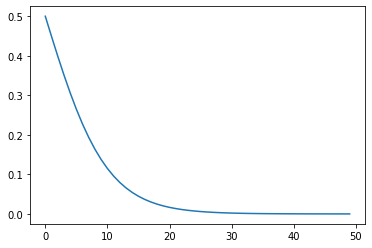

In [17]:
plt.plot(s)

In [2]:
# GPU Device
gpu_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
print("GPU device %d:" %(gpu_id), use_cuda)

GPU device 1: True


# Arguments

In [3]:
source_dir = '/media/data2/dataset/GAN_ImageData/StarGAN_128/'
target_dir = '/media/data2/dataset/GAN_ImageData/StyleGAN2_256/'

In [4]:
pretrained = './log/star/128/32x4d/aug/checkpoint.pth.tar'
resume = ''

In [5]:
# Model
model_name = 'resnext32x4d' # b0-b7 scale

# Optimization
num_classes = 2
epochs = 1000
start_epoch = 0
train_batch = 400
test_batch = 400
lr = 0.1
schedule = [50, 250, 500, 750]
momentum = 0.1
gamma = 0.1 # LR is multiplied by gamma on schedule

# CheckPoint
checkpoint = './log/star/128/32x4d/to_style2/2000shot/self' # dir
if not os.path.isdir(checkpoint):
    os.makedirs(checkpoint)
num_workers = 8

# Seed
manual_seed = 7
random.seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)

# Image
size = (128, 128)

# cutmix

cm_beta = 1.0



best_acc = 0

# sp
sp_alpha = 0.1
sp_beta = 0.1
fc_name = 'fc.'

In [6]:
state = {}
state['num_classes'] = num_classes
state['epochs'] = epochs
state['start_epoch'] = start_epoch
state['train_batch'] = train_batch
state['test_batch'] = test_batch
state['lr'] = lr
state['schedule'] = schedule
state['momentum'] = momentum
state['gamma'] = gamma

In [7]:
def data_augment(img):
    img = np.array(img)

    if random.random() < blur_prob:
        sig = np.random.uniform(0.0, 3.0)
        gaussian_blur(img, sig)

    if random.random() < jpg_prob:
        qual = 100
        img = cv2_jpg(img, qual)

    return Image.fromarray(img)


def gaussian_blur(img, sigma):
    gaussian_filter(img[:,:,0], output=img[:,:,0], sigma=sigma)
    gaussian_filter(img[:,:,1], output=img[:,:,1], sigma=sigma)
    gaussian_filter(img[:,:,2], output=img[:,:,2], sigma=sigma)


def cv2_jpg(img, compress_val):
    img_cv2 = img[:,:,::-1]
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_val]
    result, encimg = cv2.imencode('.jpg', img_cv2, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg[:,:,::-1]

In [8]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Dataset

In [9]:
train_dir = os.path.join(source_dir, 'style2/2000_shot_only')
val_target_dir = os.path.join(target_dir, 'validation')
val_source_dir = os.path.join(source_dir, 'validation')

train_aug = transforms.Compose([
    transforms.Lambda(lambda img: data_augment(img)),
    transforms.Resize(size),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_aug = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# pin_memory : cuda pin memeory use
train_loader = DataLoader(datasets.ImageFolder(train_dir, transform=train_aug),
                          batch_size=train_batch, shuffle=False, num_workers=num_workers, pin_memory=True)
val_target_loader = DataLoader(datasets.ImageFolder(val_target_dir, val_aug),
                       batch_size=test_batch, shuffle=False, num_workers=num_workers, pin_memory=True)
val_source_loader = DataLoader(datasets.ImageFolder(val_source_dir, val_aug),
                       batch_size=test_batch, shuffle=False, num_workers=num_workers, pin_memory=True)

In [10]:
# augmentation
blur_prob = 100       #Gaussian blur
jpg_prob = 100      #JPEG Compression
blog_sig = 0.5      #Random horizontal flip
cm_prob = 0.5     #Cutmix

In [11]:
for i, j in train_loader:
    break

In [12]:
img = torch.transpose(torch.transpose(i[0], 0, 1), 1, 2)

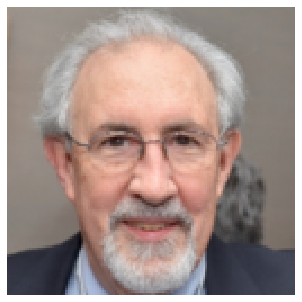

In [14]:
plt.imshow(img)
plt.axis('off'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.savefig('/home/cutz/JPEG_Compression.png', dpi=1000, bbox_inces='tight', pad_inches=0)

In [15]:
# cutmix  
rand_index = torch.randperm(i.size()[0]).cuda()
tt= j[rand_index]
boolean = j==tt
rand_index = rand_index[boolean]
lam = np.random.beta(cm_beta, cm_beta)
bbx1, bby1, bbx2, bby2 = rand_bbox(i.size(), lam)
i[boolean, :, bbx1:bbx2, bby1:bby2] = i[rand_index, :, bbx1:bbx2, bby1:bby2]

In [16]:
img = torch.transpose(torch.transpose(i[0], 0, 1), 1, 2)

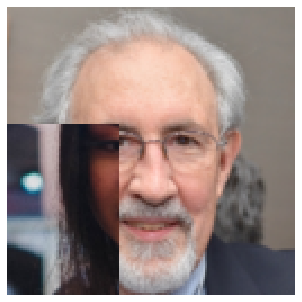

In [17]:
plt.imshow(img)
plt.axis('off'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
#plt.savefig('/home/cutz/Cutmix.png', dpi=1000, bbox_inces='tight', pad_inches=0)
print()